In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import pandas as pd
import numpy as np


In [8]:
#import dataset with all dates merged to a single table
diag_usage_df = pd.read_excel('../Data/DiagUsagePowerBI_merged.xlsx', sheet_name='connect_system')

In [9]:
diag_usage_df.sample(5)

,timestamp,siteId,billable_status,OsName,client_OS,vin,year,make,model,system,veh_desc,vci_version,scan_method,batt_voltage,result_string,result,state,city,product_type,postal_code
98222,2024-11-08 20:05:10.339,569198,BILL,Android,Android 8.1.0,1FDUF5HT6KD,2019.0,PowerStroke 6.7L,PowerStroke,Enhanced Powertrain CAN,2019 Ford PowerStroke 6.7L Enhanced Powertrain...,22.3.2439.2,quick_scan,NaN,Successfully connected to vehicle,success,TX,DOUGLASSVILLE,REPAIR,75560
159190,2025-01-20 20:55:08.861,740364,BILL,iPadOS,iPadOS 17.5.1,3GNKBHR44LS,2020.0,Chevrolet,Blazer,Enhanced Powertrain,2020 Chevrolet Blazer Enhanced Powertrain,22.3.2439.2,manual scan,14.04,Successfully connected to vehicle,success,OH,Tipp City,COLLISION,45371-8417
12552,2024-12-18 21:27:10.470,691059,BILL,Android,Android 14,3N1AB8BV1PY,2023.0,Nissan,Sentra,Enhanced Powertrain CAN,2023 Nissan Sentra Enhanced Powertrain CAN,22.3.2439.2,quick_scan,14.01,Successfully connected to vehicle,success,unknown,unknown,unknown,unknown
188149,2025-01-06 20:54:53.609,591931,BILL,Android,Android 14,3GNKBKRS7RS,2024.0,Chevrolet,Blazer,Enhanced Powertrain,2024 Chevrolet Blazer Enhanced Powertrain,22.1.2418.1,quick_scan,11.99,Successfully connected to vehicle,success,AK,ANCHORAGE,COLLISION,99501-3903
187703,2025-01-06 19:19:26.885,648065,BILL,Android,Android 8.1.0,5FNYF6H99HB,2017.0,Honda,Pilot,Enhanced Powertrain,2017 Honda Pilot Enhanced Powertrain,22.1.2418.1,quick_scan,11.52,Successfully connected to vehicle,success,NH,DERRY,REPAIR,03038-1207


In [10]:
#we are only interested in billable customers. Drop all rows where billable_status is not 'Bill' and drop the column
diag_usage_df = diag_usage_df[diag_usage_df['billable_status'] == 'BILL']
diag_usage_df = diag_usage_df.drop(columns=['billable_status'])

In [11]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182672 entries, 0 to 190262
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      182672 non-null  datetime64[ns]
 1   siteId         182672 non-null  int64         
 2   OsName         182672 non-null  object        
 3   client_OS      182672 non-null  object        
 4   vin            174142 non-null  object        
 5   year           173593 non-null  float64       
 6   make           173590 non-null  object        
 7   model          173593 non-null  object        
 8   system         182671 non-null  object        
 9   veh_desc       182672 non-null  object        
 10  vci_version    181799 non-null  object        
 11  scan_method    182672 non-null  object        
 12  batt_voltage   133995 non-null  object        
 13  result_string  182672 non-null  object        
 14  result         182672 non-null  object        
 15  state

In [14]:
#SideId ashould be int not float
diag_usage_df['siteId'] = diag_usage_df['siteId'].astype(int)

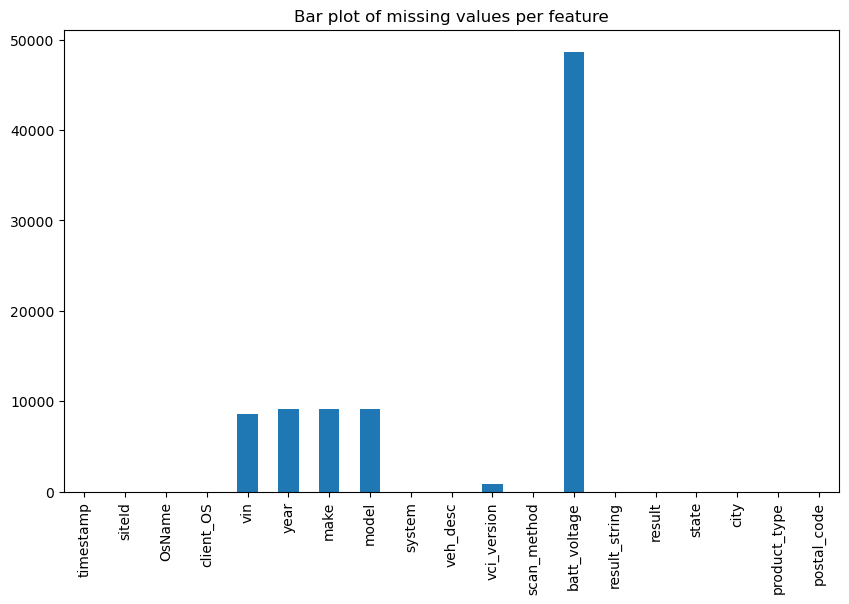

In [15]:
# Check for missing values. Note: battery voltage was only recently added to the data collection. This explains the high percentage of missing values.
diag_usage_df.isnull().sum().plot(kind='bar', figsize=(10, 6))
plt.title('Bar plot of missing values per feature')
plt.show()

In [16]:
#Look at number of unique makes. Note: the number of makes is much greater than the number of valid makes.
makes_count = diag_usage_df['make'].nunique()
makes_count

669

In [17]:
#Fix the vehicle description for Makes with multiple word names
#The vehicle description will be used to correct the make column and fill in missing values for the model and year columns. First drop rows with missing values in the vehicle description column.
diag_usage_df = diag_usage_df.dropna(subset=['veh_desc'])
#correct Mercedes Benz make to Mercedes-Benz
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bMercedes Benz\b', 'Mercedes-Benz', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bAlfa Romeo\b', 'Alfa-Romeo', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bLand Rover\b', 'Land-Rover', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bAston Martin\b', 'Aston-Martin', regex=True)
#correct multi word models to single word models
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bE Class\b', 'E-Class', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bGLE Class\b', 'E-Class', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bRange Rover\b', 'Range-Rover', regex=True)

In [18]:
#Fix the model column for multiple word makes
multi_word_makes = ['Mercedes-Benz', 'Land-Rover', 'Alfa-Romeo', 'Aston-Martin']    
for make in multi_word_makes:
    condition = diag_usage_df['veh_desc'].str.contains(make, na=False)
    diag_usage_df.loc[condition, 'model'] = diag_usage_df.loc[condition, 'veh_desc'].str.split().str[2]
    diag_usage_df.loc[condition, 'make'] = diag_usage_df.loc[condition, 'veh_desc'].str.split().str[1]


In [19]:
#There was an issue where the make was set to the model text. This has been corrected but some users have not updated their application software so the make is invalid for many records.
#The make from the vehicle description will be used to correct the invalid makes.
diag_usage_df['make'] = diag_usage_df['veh_desc'].str.split(' ', expand=True)[1]
makes = diag_usage_df['make'].value_counts()
diag_usage_df.drop(diag_usage_df[diag_usage_df['make'] == ''].index, inplace=True)
#diag_usage_df['make'].value_counts()
diag_usage_df.shape[0]

173593

In [20]:
diag_usage_df['year'] = diag_usage_df['year'].astype(int)
diag_usage_df['year'] = diag_usage_df['year'].astype(str)

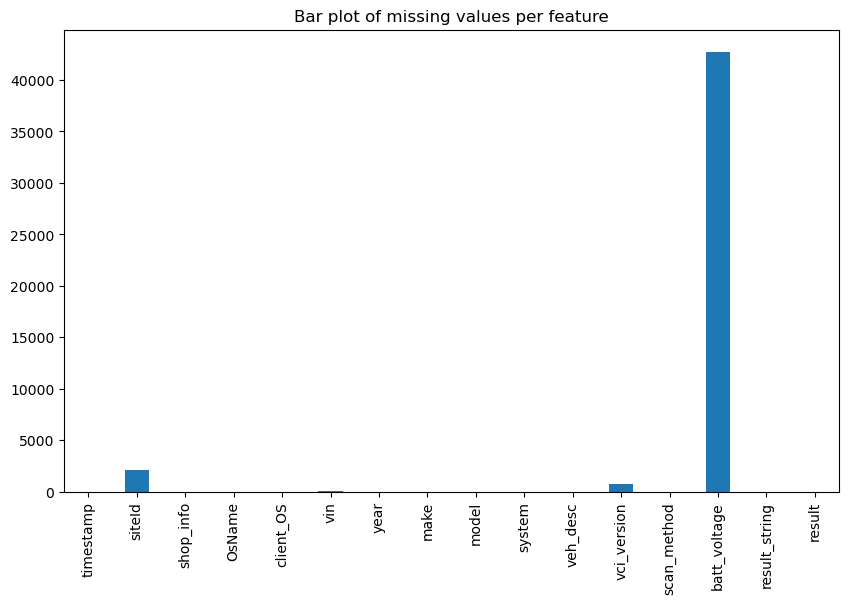

In [86]:
# Check for missing values. Note: battery voltage was only recently added to the data collection. This explains the high percentage of missing values.
diag_usage_df.isnull().sum().plot(kind='bar', figsize=(10, 6))
plt.title('Bar plot of missing values per feature')
plt.show()

In [21]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173593 entries, 0 to 190262
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      173593 non-null  datetime64[ns]
 1   siteId         173593 non-null  int32         
 2   OsName         173593 non-null  object        
 3   client_OS      173593 non-null  object        
 4   vin            173553 non-null  object        
 5   year           173593 non-null  object        
 6   make           173593 non-null  object        
 7   model          173593 non-null  object        
 8   system         173593 non-null  object        
 9   veh_desc       173593 non-null  object        
 10  vci_version    172902 non-null  object        
 11  scan_method    173593 non-null  object        
 12  batt_voltage   132821 non-null  object        
 13  result_string  173593 non-null  object        
 14  result         173593 non-null  object        
 15  state

In [23]:
#find features with high percentage of missing values
(diag_usage_df.isna().sum() / len(diag_usage_df)) * 100

timestamp         0.000000
siteId            0.000000
OsName            0.000000
client_OS         0.000000
vin               0.023042
year              0.000000
make              0.000000
model             0.000000
system            0.000000
veh_desc          0.000000
vci_version       0.398058
scan_method       0.000000
batt_voltage     23.487122
result_string     0.000000
result            0.000000
state             0.000000
city              0.000000
product_type      0.000000
postal_code       0.000000
dtype: float64

In [28]:
#Since the missing values are a small % of the total data, we can drop them. However, the batt_voltage has a high percentage of missing values, so for now we will set its missing values to zero
diag_usage_df['batt_voltage'].fillna(0, inplace=True)
diag_usage_df.dropna(inplace=True)

In [29]:
#The diagnostic interface will return 'no data' if the battery voltage is not available. We will remove these records from the dataset.
no_data_count = diag_usage_df['batt_voltage'].str.contains('no data', case=False).sum()
invalid_format_count = diag_usage_df['batt_voltage'].str.contains(',').sum()
print(f"number of 'no data' values: {no_data_count} number of invalid formated: {invalid_format_count}")

number of 'no data' values: 313 number of invalid formated: 469


In [30]:
#cleanup the invalid values from the batt_voltage column
diag_usage_df = diag_usage_df[~diag_usage_df['batt_voltage'].str.contains('no data', case=False, na=False)]
diag_usage_df = diag_usage_df[~diag_usage_df['batt_voltage'].str.contains(',', na=False)]

In [31]:
#convert the batt_voltage column to float
diag_usage_df['batt_voltage'] = diag_usage_df['batt_voltage'].apply(lambda x: round(float(x), 2))
#replace outlier batt voltage values with zero
diag_usage_df.loc[diag_usage_df['batt_voltage'] < 0, 'batt_voltage'] = 0

In [32]:
#note: battery voltage values of zero are not valid. They are either missing or the vehicle is not running.
diag_usage_df[diag_usage_df['batt_voltage'] > 0]['batt_voltage'].describe()

count    131672.000000
mean         12.687064
std           1.306304
min           1.480000
25%          11.640000
50%          12.160000
75%          14.010000
max          22.690000
Name: batt_voltage, dtype: float64

In [33]:
diag_usage_df['batt_voltage'] = diag_usage_df['batt_voltage'].apply(lambda x: round(float(x) / 100, 2) if float(x) > 100 else round(float(x), 2))
diag_usage_df['batt_voltage'] = diag_usage_df['batt_voltage'].apply(lambda x: 0 if float(x) < 0 else round(float(x), 2))

In [34]:
#diag_usage_df.describe().round(2).T
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172081 entries, 0 to 190262
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      172081 non-null  datetime64[ns]
 1   siteId         172081 non-null  int32         
 2   OsName         172081 non-null  object        
 3   client_OS      172081 non-null  object        
 4   vin            172081 non-null  object        
 5   year           172081 non-null  object        
 6   make           172081 non-null  object        
 7   model          172081 non-null  object        
 8   system         172081 non-null  object        
 9   veh_desc       172081 non-null  object        
 10  vci_version    172081 non-null  object        
 11  scan_method    172081 non-null  object        
 12  batt_voltage   172081 non-null  float64       
 13  result_string  172081 non-null  object        
 14  result         172081 non-null  object        
 15  state

In [35]:
diag_usage_df.describe().round(2).T

,count,mean,min,25%,50%,75%,max,std
timestamp,172081,2024-12-05 15:06:57.419735040,2024-10-01 20:24:02.463000,2024-11-01 18:33:56.412000,2024-12-04 16:18:29.067000064,2025-01-09 19:21:40.870000128,2025-02-09 16:28:29.957000,NaN
siteId,172081.0,467312.1,10388.0,258509.0,482188.0,667934.0,888822.0,243412.69
batt_voltage,172081.0,9.71,0.0,10.78,11.78,13.78,22.69,5.5


In [36]:
nan_count = diag_usage_df['batt_voltage'].isna().sum()
#diag_usage_df['batt_voltage'].value_counts()
nan_count

0

In [37]:
#correct Blazer EV model name
contains_blazer_and_ev = diag_usage_df['veh_desc'].str.contains('blazer ev', case=False, na=False) & diag_usage_df['model'].str.contains('ev', case=False, na=False)
diag_usage_df.loc[contains_blazer_and_ev, 'model'] = 'Blazer EV'

In [39]:
systems = diag_usage_df['system'].unique()
print(f"Number of unique systems: {len(systems)}")
#diag_usage_df['system'] = diag_usage_df['system'].apply(lambda x: 'Enhanced Powertrain' if 'enhanced powertrain' in str.lower(x) else x)

Number of unique systems: 891


In [40]:
system_category_mapping = {
    'Enhanced Powertrain': [
        'enhanced powertrain', 'digital motor', 'dme', 'powertrain', 'engine control', 'engine', 'digital diesel', 'drivetrain', 'hybrid control', 'ima motor system'
    ],	
	'Fuel Pump': [
        'fuel pump'
    ],
	'Drive Motor Control System': [
        'motor generator', 'drive motor control module', 'traction energy', 'drive motor', 'motor control', 'drive motor control', 'traction electric machine electronics'
    ],    
    'Telematics': [
        'telematic', 'wireless'
    ],  
    'Airbag Control System': [
        'supplemental inflatable restraint', 'supplemental restraint', 'airbag control module', 'srs-airbag', 'srs can',
        'sir', 'airbag', 'inflatable restraint', 'restraint system', 'srs', 'airbag module', 'active safety', 'pre collision', 'precollision'
    ],
	'ADAS': [
        'radar', 'adas', 'driver assist', 'blind spot', 'adaptive cruise', 'rear camera', 'front camera', 'object detection', 'object sensor', 'cruise control', 'lane camera', 'frontview camera', 'sonar', 'acoustic', 'pedestrian protection',
        'lane change', 'lane departure', 'side obstacle', 'side optical detection', 'collision avoidance assist', 'emergency braking system', 'reverse automatic braking', 'camera module', 'lane change', 'parktronics', 'camera system'
    ],
	'Infotainment System': [
        'instrument cluster', 'ipc', 'instrument control', 'instrument panel', 'sync', 'information control', 'information display', 'information center', 'information module', 'head unit', 'headunit', 'hands free'
    ],
	'Power Steering System' : [
        'power steering', 'eps', 'steering assist', 'steering angle', 'steering column', 'sas control', 'steering wheel'
    ],
    'Transmission Control System': [
        'transmission control', 'tcm', 'transmission', 'cvt', 'transfer case', 'differential', 'transaxle', 'transmission control module', 'final drive', 'gear shift', 'e-shifter', '4x4', 'four wheel', '4wd', '4wal', 'gear select', 'all-wheel'
    ],    
    'Body Control System': [
        'body control', 'bcm', 'door', 'main body', 'seat memory', 'seat module', 'body domain', 'body basic', 'central elect', 'cabin compartment', 'chime alarm', 'car access', 'keyless entry', 'keyless start', 'keyless access', 'keyless ignition', 'keyless vehicle', 'keyless', 'sliding roof'
    ],    
    'Chassis Control System': [
        'chassis control module', 'chassis control', 'suspension', 'tailgate', 'liftgate', 'tail gate', 'lift gate'
    ],    
    'HVAC Control System': [
        'hvac control module', 'hvac', 'air conditioning', 'climate control', 'ccm', 'heater', 'climate', 'heating and ac'
    ],
    'Fuel System': [
        'fuel pump control', 'fuel system', 'fuel control'
    ],
    'Gateway': [
        'gateway', 'vehicle communication interface', 'vehicle system interface'
    ],
    'Crash Safety System': [
        'safety belt', 'crash safety', 'crash', 'restraint', 'tensioning', 'tensioner'
    ],
	'Park Assist': [
        'park assist', 'parking', 'park aid', 'parktronics', 'parktronic system'
    ],
	'TPMS': [
        'tire pressure', 'tpms', 'tpws', 'tyre pressure'
    ],
	'Theft Deterrent': [
        'theft', 'smart key', 'immobilizer', 'security', 'passlock'
    ],
	'Occupant Sensing System': [
        'occ', 'occupant', 'ocs', 'seat weight sensor', 'passenger presence', 'ppm', 'weight sensing system', 'weight control'
    ],
	'Accessory Power System': [
        'dc dc converter', 'ddw', 'accessory power', 'apm'
    ],
	'Battery Management System': [
        'battery energy', 'battery control', 'becm', 'battery system', 'hv batt', 'battery monitoring', 'battery pack control module'
    ],
	'Head Lamp Control System': [
        'head lamp', 'headlight', 'headlamp'
    ],
    'Radio Control System': [
        'radio', 'audio', 'entertainment', 'rcm', 'amplifier', 'sound system'
    ],
    'General Electronics System': [
        'general electronics', 'gem', 'electrical machine'
    ],
    'Braking System': [
        'anti-lock brake', 'abs', 'tcs', 'brake control', 'brake', 'dynamic stablity', 'antilock brakes', 'brake system', 'esc', 'brake epb', 'stability', 'vehicle dynamics', 'esp', 'asc'
    ]
}


In [41]:
def map_system_to_category(system_name):
    # Iterate over the system category mapping dictionary and return the common system name if found
    for key, values in system_category_mapping.items():
        if any(value in system_name.lower() for value in values):
            return key
    return 'other'  # If no mapping is found, return the original name

In [42]:
diag_usage_df['system_category'] = diag_usage_df['system'].apply(map_system_to_category)
diag_usage_df.sample(5)

,timestamp,siteId,OsName,client_OS,vin,year,make,model,system,veh_desc,vci_version,scan_method,batt_voltage,result_string,result,state,city,product_type,postal_code,system_category
100805,2024-11-08 22:15:01.651,752078,iPadOS,iPadOS 17.5.1,4T1B11HK3JU,2018,Toyota,Camry,Enhanced Powertrain CAN,2018 Toyota Camry Enhanced Powertrain CAN,22.1.2418.1,manual scan,0.00,Failed to connect to vehicle,failed,TX,LAREDO,COLLISION,78041,Enhanced Powertrain
90728,2024-10-03 13:48:59.851,453181,Android,Android 14,SALGS2RK7LA,2020,Land-Rover,Range-Rover,Enhanced Powertrain CAN,2020 Land-Rover Range-Rover Enhanced Powertrai...,22.1.2418.1,quick_scan,0.00,Successfully connected to vehicle,success,QC,LONGUEUIL,REPAIR,J4K 3R7,Enhanced Powertrain
79710,2024-10-10 13:18:01.564,122979,Android,Android 14,1N4BL4CW3KN,2019,Nissan,Altima,Enhanced Powertrain CAN,2019 Nissan Altima Enhanced Powertrain CAN,22.1.2418.1,quick_scan,0.00,Successfully connected to vehicle,success,IN,AVON,REPAIR,46123-9058,Enhanced Powertrain
164387,2025-01-16 14:18:29.024,418769,Android,Android 10,1FTNR2ZM3FK,2015,Ford,Transit,Enhanced Powertrain CAN,2015 Ford Transit Enhanced Powertrain CAN,22.3.2439.2,quick_scan,11.52,Successfully connected to vehicle,success,MD,Dundalk,COLLISION,21222-3636,Enhanced Powertrain
79887,2024-10-22 13:41:15.508,245163,Android,Android 14,1FM5K8HT5GG,2016,Ford,Explorer,Enhanced Powertrain CAN,2016 Ford Explorer Enhanced Powertrain CAN,22.3.2439.2,quick_scan,0.00,Successfully connected to vehicle,success,unknown,unknown,unknown,unknown,Enhanced Powertrain


In [43]:
other_systems_df = diag_usage_df[diag_usage_df['system_category'] == 'other']
other_systems = other_systems_df['system'].value_counts()
for system in other_systems.index:
    print(system)

Cluster Module (CLU)
Valvetronic (VTC)
Airmatic (EHNR212)
4 WAL
Multiplex Integrated Control Unit System
Totally Integrated Power Module
ETACS CAN
Variable Geometry Turbo
AT / CDC
AIRmatic (SLF211)
Shift CAN
Intrusion Transceiver Module
Adaptive Front Lighting System (AFLS)
Adaptive Lighting CAN Rev4 (AFS)
CCS CAN
SH-AWD
Glow Plug Control Module
Electronic Shifter Module
Valvetronic2 (VTC2)
Selective Catalytic Reduction (SCR)
Digital Signal Processor MCAN 14229
Power Window Module System
Adaptive Front Lighting System
Auto Light ECU System
Active Control Mount System
ELC - AT
Overhead Console (OHC)
Integrated Unit Module
Front Control Interface Module MCAN 14229
Assist Step Control Module
Video Processing Control Module
Virtual Integration System (VIP_I20)
EPB CAN
Integrated Center Stack
35 - Central Locking
Frontal Light Electronics Left (FLE02_L)
Rear Gate Module - RGM
Front Display Interface Module MCAN
Shift UDS
Remote Function Actuator MCAN
Smart Entry System
Illuminated Light Con

In [67]:
#Determine the percentage of each system category
system_counts_df = diag_usage_df['system_category']
total_records = system_counts_df.shape[0]
system_counts = system_counts_df.value_counts()
system_counts_percent = system_counts / total_records * 100
system_counts_percent

system_category
Enhanced Powertrain            95.461250
Braking System                  1.406940
Airbag Control System           1.023076
Transmission Control System     0.416271
Body Control System             0.276583
Crash Safety System             0.234117
Occupant Sensing System         0.196681
TPMS                            0.179918
ADAS                            0.139688
other                           0.122926
Power Steering System           0.072638
HVAC Control System             0.070403
Infotainment System             0.060904
Drive Motor Control System      0.052523
Fuel Pump                       0.046376
Radio Control System            0.039671
Park Assist                     0.035201
Chassis Control System          0.031290
General Electronics System      0.030173
Theft Deterrent                 0.027938
Gateway                         0.023468
Battery Management System       0.018439
Head Lamp Control System        0.013969
Telematics                      0.010058


In [44]:
#Determine the percentage of each system category excluding the enhanced powertrain systems
system_counts_df = diag_usage_df[diag_usage_df['system_category'] != 'Enhanced Powertrain']['system_category']
total_records = system_counts_df.shape[0]
system_counts = system_counts_df.value_counts()
system_counts_percent = system_counts / total_records * 100
system_counts_percent
#total_records

system_category
Braking System                 30.813804
Airbag Control System          22.804533
Transmission Control System     9.142416
Body Control System             5.987638
Crash Safety System             5.215040
Occupant Sensing System         4.403811
TPMS                            3.966006
ADAS                            3.090394
other                           2.742725
Power Steering System           1.622457
HVAC Control System             1.493690
Infotainment System             1.274788
Drive Motor Control System      1.158898
Fuel Pump                       1.043008
Radio Control System            0.901365
Park Assist                     0.733969
Chassis Control System          0.695339
General Electronics System      0.656709
Theft Deterrent                 0.592326
Gateway                         0.515066
Battery Management System       0.424929
Head Lamp Control System        0.296163
Telematics                      0.231780
Fuel System                     0.141643


In [45]:
#Change result from success/failed to 1/0
diag_usage_df['result'] = diag_usage_df['result'].map({'success': 1, 'failed': 0})
diag_usage_df['year'] = diag_usage_df['year'].astype(str)
#remove vci_version with text demo
diag_usage_df = diag_usage_df[~diag_usage_df['vci_version'].str.lower().str.contains('demo', na=False)]
diag_usage_df = diag_usage_df[~diag_usage_df['vci_version'].str.lower().str.contains('dev', na=False)]

In [46]:
#remove system from vehicle description
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].str.split().str[:3].str.join(' ')
diag_usage_df.sample(5)

,timestamp,siteId,OsName,client_OS,vin,year,make,model,system,veh_desc,vci_version,scan_method,batt_voltage,result_string,result,state,city,product_type,postal_code,system_category
126111,2024-11-15 19:35:34.434,444684,Android,Android 8.1.0,1G1BE5SM8K7,2019,Chevrolet,Cruze,Enhanced Powertrain,2019 Chevrolet Cruze,21.3.2337.1,quick_scan,11.96,Successfully connected to vehicle,1,IN,BEDFORD,COLLISION,47421-2323,Enhanced Powertrain
162350,2025-01-20 14:22:40.511,878188,iOS,iOS 18.2.1,1FTEX1EP4FK,2015,Ford,F150,Enhanced Powertrain CAN,2015 Ford F150,22.3.2439.2,manual scan,10.99,Successfully connected to vehicle,1,QC,SHERBROOKE,COLLISION,J1J 2E9,Enhanced Powertrain
80463,2024-10-07 18:05:50.289,397539,Android,Android 8.1.0,1G1BE5SM8H7,2017,Chevrolet,Cruze,Enhanced Powertrain,2017 Chevrolet Cruze,22.1.2418.1,manual scan,0.00,Successfully connected to vehicle,1,NC,Yadkinville,COLLISION,27055-7852,Enhanced Powertrain
154141,2025-01-20 17:02:09.568,850255,Android,Android 14,4T1DAACK5SU,1996,Toyota,Camry,Enhanced Powertrain,1996 Toyota Camry,22.3.2439.2,quick_scan,14.83,Communications could not be established with t...,0,IA,Iowa City,COLLISION,52240-4529,Enhanced Powertrain
116798,2024-11-13 14:30:46.234,748098,iOS,iOS 17.6.1,1C4PJMDXXJD,2018,Jeep,Cherokee,Enhanced Powertrain,2018 Jeep Cherokee,22.3.2439.2,quick_scan,14.39,Successfully connected to vehicle,1,NC,PINEHURST,COLLISION,28374-8809,Enhanced Powertrain


In [47]:
#Clean up result_string
#replace text '<div>' with empty string in result string
diag_usage_df['result_string'] = diag_usage_df['result_string'].str.replace('<div>', '', regex=False)

diag_usage_df.loc[diag_usage_df['result_string'].str.contains('Already connected', na=False), 'result_string'] = 'Already connected'
diag_usage_df.loc[diag_usage_df['result_string'].str.contains('Success', na=False), 'result_string'] = 'Successfully connected'
diag_usage_df.loc[diag_usage_df['result_string'].str.contains('Communications could not be established with the system', na=False), 'result_string'] = 'Failed to connect to system'
diag_usage_df.loc[diag_usage_df['result_string'].str.contains('Bluetooth', na=False), 'result_string'] = 'Bluetooth Error'
diag_usage_df.loc[diag_usage_df['result_string'].str.contains('VCI did not respond', na=False), 'result_string'] = 'VCI did not respond'
diag_usage_df.loc[diag_usage_df['result_string'].str.contains('VCI returned invalid data', na=False), 'result_string'] = 'VCI returned invalid data'
diag_usage_df['result_string'].value_counts()

result_string
Successfully connected          152016
Failed to connect to system      16034
Failed to connect to vehicle      3737
VCI did not respond                124
Already connected                   88
Bluetooth Error                      2
VCI returned invalid data            2
Name: count, dtype: int64

In [48]:
#remove years 1994-1995 as they are not offcially supported
diag_usage_df = diag_usage_df[~diag_usage_df['year'].isin([1994, 1995])]
#remove vins with all zeros
diag_usage_df = diag_usage_df[~diag_usage_df['vin'].isin(['00000000000', '00000000000'])]

In [49]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171997 entries, 0 to 190262
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        171997 non-null  datetime64[ns]
 1   siteId           171997 non-null  int32         
 2   OsName           171997 non-null  object        
 3   client_OS        171997 non-null  object        
 4   vin              171997 non-null  object        
 5   year             171997 non-null  object        
 6   make             171997 non-null  object        
 7   model            171997 non-null  object        
 8   system           171997 non-null  object        
 9   veh_desc         171997 non-null  object        
 10  vci_version      171997 non-null  object        
 11  scan_method      171997 non-null  object        
 12  batt_voltage     171997 non-null  float64       
 13  result_string    171997 non-null  object        
 14  result           171997 n

In [54]:
attributes = ['state', 'city', 'product_type', 'postal_code']
for attribute in attributes:
    num_unknown = diag_usage_df[attribute].str.lower().str.contains('unknown', na=False).sum()
    unknown_percent = num_unknown / diag_usage_df.shape[0] * 100
    print(f'Percentage of unknown values for {attribute}: {unknown_percent} num unknown: {num_unknown}')    

Percentage of unknown values for state: 9.301325023110868 num unknown: 15998
Percentage of unknown values for city: 9.301325023110868 num unknown: 15998
Percentage of unknown values for product_type: 9.301325023110868 num unknown: 15998
Percentage of unknown values for postal_code: 9.301325023110868 num unknown: 15998


In [50]:
diag_usage_df.to_excel('DiagUsage_Cleaned.xlsx', index=False)